# Imports & config

In [1]:
import json
import os
import random
import time

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

import timm
import mediapipe as mp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\Kirill\Documents\GitHub\Virtual-Board\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [3]:
IMAGE_DIR = 'hand_labels_synth'
BATCH_SIZE = 16
EPOCHS = 10
SEED = 101

In [4]:
# Зафиксируем сиды
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    
set_seed(seed=SEED)

# Обзор и подготовка данных

В папке содержится 4 папки синтетических данных (6546 + 3243 + 2348 + 2124 = 14261 annotations) и папка с примером выходных данных исследования, которое делали авторы датасета. Она нам не понадобится. А 4 папки синтетических данных мы позже объединим для обучения.

In [5]:
split1 = json.load(open(IMAGE_DIR + '/synth1/0002.json'))

Файл содержит два раздела, координаты ключевых точек руки и флаг левой, правой руки

In [6]:
split1.keys()

dict_keys(['hand_pts', 'is_left'])

In [7]:
split1['hand_pts'][0]

[152.03500366210938, 209.26100158691406, 1.0]

Посмотрим на наши данные, или картинки

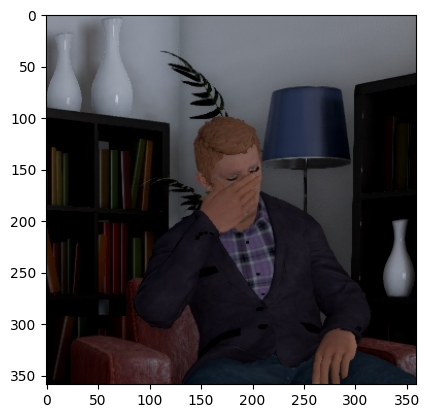

In [8]:
image = cv2.imread(IMAGE_DIR + '/synth1/0002.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

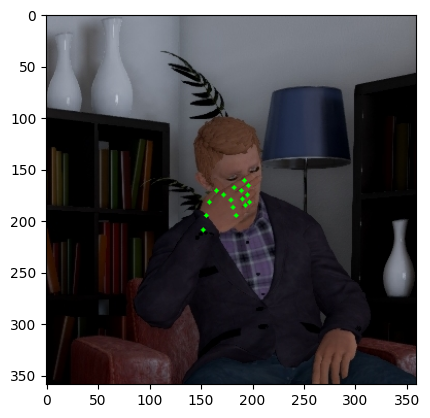

In [9]:
for i in range(0, len(split1['hand_pts'])):
    if split1['hand_pts'][i] != 0:
        cv2.circle(image, (int(split1['hand_pts'][i][0]), int(split1['hand_pts'][i][1])), 0, (0, 255, 0), 3)
plt.imshow(image)

Отлично все точки отображаются. Сделаем датафрейм для удобства обработки данного датасета

In [10]:
def prepare_data(folder_name):
    # сначала формируем списки файлов (img & json)
    all_paths_img = []
    all_paths_json = []
    folders = sorted([f for f in os.listdir(folder_name) 
                      if os.path.isdir(os.path.join(folder_name, f))])[1:]

    for folder in folders:
        temp_paths_img = [os.path.join(folder_name, folder, f) for f 
                          in os.listdir(os.path.join(folder_name, folder)) if (f[-3:] == 'jpg')]
        temp_paths_json = [os.path.join(folder_name, folder, f) for f 
                           in os.listdir(os.path.join(folder_name, folder)) if (f[-4:] == 'json')]
        all_paths_img += temp_paths_img
        all_paths_json += temp_paths_json
    
    all_paths_img = sorted(all_paths_img)
    all_paths_json = sorted(all_paths_json)
    
    # сделаем датафрейм
    df = pd.DataFrame(columns=['path', 'points'])
    empty_list_pts = [[0, 0] for i in range(21)]
    
    for i in range(len(all_paths_img)):
        
        temp_json = json.load(open(all_paths_json[i]))
        temp_hand = temp_json['is_left']

        # чтобы избавиться от рук, объединим точки. сначала будут точки правой руки
        if temp_hand:
            final_pts = np.array(empty_list_pts + [pt[:2] for pt in temp_json['hand_pts']]).astype(int)
        else:
            final_pts = np.array([pt[:2] for pt in temp_json['hand_pts']] + empty_list_pts).astype(int)

        df.loc[i,:] = [all_paths_img[i], final_pts]

    return df

In [11]:
df = prepare_data(IMAGE_DIR)

In [12]:
df.head()

,path,points
0,hand_labels_synth\synth1\0001.jpg,"[[154, 136], [164, 149], [172, 162], [175, 176..."
1,hand_labels_synth\synth1\0002.jpg,"[[152, 209], [155, 195], [158, 182], [165, 171..."
2,hand_labels_synth\synth1\0003.jpg,"[[148, 158], [160, 156], [170, 156], [181, 161..."
3,hand_labels_synth\synth1\0004.jpg,"[[206, 237], [222, 232], [237, 231], [253, 233..."
4,hand_labels_synth\synth1\0005.jpg,"[[162, 139], [172, 152], [179, 165], [181, 179..."


# Созданние датасета
Теперь сформируем датасет

In [13]:
class HandsDataset(Dataset):

    def __init__(self, meta):
        self.meta = meta
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(), 
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):

        image_name = self.meta.loc[idx,'path']
        image = Image.open(image_name).convert('RGB')
        image = np.asarray(image)
        old_shape = image.shape[0]
        image = self.preprocessing(image=image)['image']
        
        # пересчитываем координаты с учетом резайса картинки
        keypoints = self.meta.loc[idx, 'points'] / (old_shape / 224)
        keypoints = torch.tensor([item for sublist in keypoints for item in sublist])

        return image.float(), keypoints.float(), image_name

Разобьем на подвыборки: обучения и тестирования

In [14]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=SEED)

dataset_train = HandsDataset(train_df.reset_index(drop=True))
dataset_test = HandsDataset(val_df.reset_index(drop=True))

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=0)

# Созднание модели и ее обучение
Возьмем предобученную модель `tf_efficientnetv2_s_in21k` и заменим классификатор 

In [15]:
model = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=True).to(device)

additional_layers = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU()
)
model.classifier = nn.Sequential(
    nn.Linear(256, 84)
)

model.classifier = nn.Sequential(additional_layers, model.classifier)
model.to(device);

c:\Users\Kirill\Documents\GitHub\Virtual-Board\env\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


Лосс функция и оптимизатор

In [16]:
loss_f = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

## Обучение

In [17]:
start = time.time()
for epoch_i in range(1, EPOCHS + 1):

    print(f'---------------------epoch:{epoch_i}/{EPOCHS}---------------------')

    # loss
    avg_train_loss = 0
    avg_val_loss = 0
    predicted_labels_list = None
    true_labels_list = None

    ############## Train #############
    model.train()
    train_pbar = tqdm(train_loader, desc="Training")
    for X, y, _ in (train_pbar):
        X_batch = X.to(device)
        y_batch = y.to(device)

        optimizer.zero_grad()
        res = model.forward(X_batch)
    
        loss = loss_f(res.float(), y_batch.float())

        if torch.cuda.is_available():
            train_pbar.set_postfix(gpu_load=f"{torch.cuda.memory_allocated() / 1024 ** 3:.2f}GB",
                                   loss=f"{loss.item():.4f}")
        else:
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        loss.backward()
        optimizer.step()
        
        avg_train_loss += loss * len(y_batch)
        del X, res

    ########## VALIDATION ###############
    model.eval()
    valid_pbar = tqdm(valid_loader, desc="Testing")
    with torch.no_grad():
        for X, y, _ in (valid_pbar):
            X_batch = X.to(device)
            y_batch = y.to(device)

            res = model.forward(X_batch)
            
            loss = loss_f(res.float(), y_batch.float())
            avg_val_loss += loss * len(y_batch)
            valid_pbar.set_postfix(loss=f"{loss.item():.4f}")

            res = res.detach().cpu().numpy()
            y_batch = y_batch.cpu().numpy()
            if predicted_labels_list is None:
                predicted_labels_list = res
                true_labels_list = y_batch
            else:
                predicted_labels_list = np.concatenate([predicted_labels_list, res], axis=0)
                true_labels_list = np.concatenate([true_labels_list, y_batch], axis=0)

            del X, res
            

    torch.cuda.empty_cache()

    avg_train_loss = avg_train_loss / len(dataset_train)
    avg_val_loss = avg_val_loss / len(dataset_test)

    all_predicted_labels = np.vstack(predicted_labels_list)
    all_true_labels = np.vstack(true_labels_list)
    all_true_labels = np.squeeze(all_true_labels)

    
    mae_per_output = np.mean(np.abs(all_true_labels - all_predicted_labels), axis=0)
    mean_mae = np.mean(mae_per_output)
    print(f'Epoch: {epoch_i}, lr_rate {optimizer.param_groups[0]["lr"]}')

    print("Loss_train: %0.4f| Loss_valid: %0.4f|" % (avg_train_loss, avg_val_loss))
    print(f"Mean MAE: {mean_mae:.<5g}")

    torch.save(model, f"model_ep_{epoch_i}.pt")

elapsed_time = time.time() - start
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"Elapsed total time: {hours:02d}:{minutes:02d}:{seconds:02d}")


---------------------epoch:1/10---------------------


Testing: 100%|██████████| 268/268 [00:55<00:00,  4.86it/s, loss=301.4258]


Epoch: 1, lr_rate 0.0001
Loss_train: 920.9258| Loss_valid: 268.9437|
Mean MAE: 7.72566
---------------------epoch:2/10---------------------


Testing: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, loss=288.2529]


Epoch: 2, lr_rate 0.0001
Loss_train: 259.0815| Loss_valid: 245.7030|
Mean MAE: 7.16251
---------------------epoch:3/10---------------------


Testing: 100%|██████████| 268/268 [01:13<00:00,  3.62it/s, loss=219.7921]


Epoch: 3, lr_rate 0.0001
Loss_train: 236.4673| Loss_valid: 210.3721|
Mean MAE: 6.72727
---------------------epoch:4/10---------------------


Testing: 100%|██████████| 268/268 [01:13<00:00,  3.65it/s, loss=197.8297]


Epoch: 4, lr_rate 0.0001
Loss_train: 188.3875| Loss_valid: 146.4775|
Mean MAE: 5.79307
---------------------epoch:5/10---------------------


Testing: 100%|██████████| 268/268 [01:15<00:00,  3.54it/s, loss=157.5840]


Epoch: 5, lr_rate 0.0001
Loss_train: 128.7708| Loss_valid: 105.8259|
Mean MAE: 4.99383
---------------------epoch:6/10---------------------


Testing: 100%|██████████| 268/268 [00:30<00:00,  8.92it/s, loss=85.3406] 


Epoch: 6, lr_rate 0.0001
Loss_train: 88.8431| Loss_valid: 66.9078|
Mean MAE: 3.99016
---------------------epoch:7/10---------------------


Testing: 100%|██████████| 268/268 [01:17<00:00,  3.46it/s, loss=86.3382] 


Epoch: 7, lr_rate 0.0001
Loss_train: 59.0588| Loss_valid: 58.5095|
Mean MAE: 3.77802
---------------------epoch:8/10---------------------


Testing: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s, loss=62.0986] 


Epoch: 8, lr_rate 0.0001
Loss_train: 46.2146| Loss_valid: 41.2282|
Mean MAE: 3.12358
---------------------epoch:9/10---------------------


Testing: 100%|██████████| 268/268 [01:15<00:00,  3.55it/s, loss=51.8424] 


Epoch: 9, lr_rate 0.0001
Loss_train: 35.7163| Loss_valid: 34.1150|
Mean MAE: 2.78895
---------------------epoch:10/10---------------------


Testing: 100%|██████████| 268/268 [01:16<00:00,  3.52it/s, loss=50.0344] 


Epoch: 10, lr_rate 0.0001
Loss_train: 31.1743| Loss_valid: 33.6114|
Mean MAE: 2.67909
Elapsed total time: 01:00:28


10 эпох обучения хватит для оценки предварительных результатов. Проверим, как справляется с предсказанием обученная модель

In [17]:
model = torch.load("model_ep_10.pt", map_location="cpu")
model.eval();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


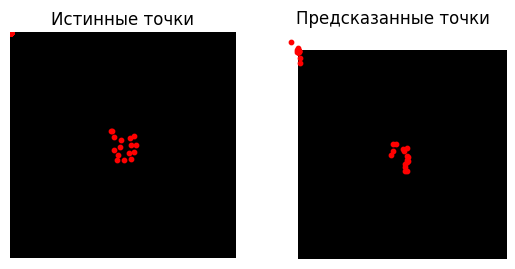

In [18]:
img, target, _ = dataset_test[random.randint(0,len(dataset_test))]

target = target.detach().cpu().numpy()
target = np.array([target[i:i+2] for i in range(0, len(target), 2)])
model.to('cpu')

pred = model.forward(img.unsqueeze(0))[0]
pred = pred.detach().cpu().numpy()
pred = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

img = img.numpy()

# Отображение картинок
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.transpose(img, (1, 2, 0)))
axs[0].scatter(target[:, 0], target[:, 1], color='red', s=10)
axs[0].axis('off')
axs[0].set_title('Истинные точки')

axs[1].imshow(np.transpose(img, (1, 2, 0)))
axs[1].scatter(pred[:, 0], pred[:, 1], color='red', s=10)
axs[1].axis('off')
axs[1].set_title('Предсказанные точки')

# Показать график
plt.show()

Визуально оценить, как модель справляется довольно сложно. Посмотрим на нее в сравнении c медиапайпом

# Сравнение с mediapipe

Случайчая картинка

In [31]:
img, target, image_path  = dataset_test[random.randint(0, len(dataset_test))]

Предсказания медиапайпа

In [32]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_resize = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_AREA)

results = hands.process(img_resize)
results_xy = []
for hand_landmarks in results.multi_hand_landmarks:
        for landmark in hand_landmarks.landmark:
            results_xy.append(landmark.x)
            results_xy.append(landmark.y)

Трансформируем координаты для всех трех значений: Истиных координат, предсказанных нашей моделью, предсказанных медиапайпом

In [33]:
target = target.detach().cpu().numpy()
target = np.array([target[i:i+2] for i in range(0, len(target), 2)])

pred = model.forward(img.unsqueeze(0))[0]
pred = pred.detach().cpu().numpy()
pred = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

results_xy = [i * 224 // 1 for i in results_xy]
results_xy_c = np.array([results_xy[i:i+2] for i in range(0, len(results_xy), 2)])

Отображаем получившийся результат

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


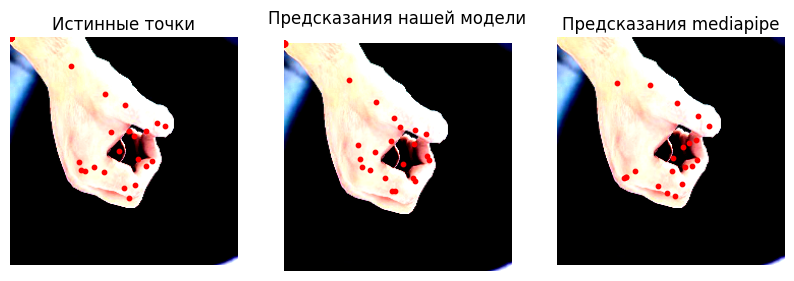

In [34]:
img = img.numpy()

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Первая картинка
axs[0].imshow(np.transpose(img, (1, 2, 0)))
axs[0].scatter(target[:, 0], target[:, 1], color='red', s=10)
axs[0].axis('off')
axs[0].set_title('Истинные точки')
# Вторая картинка
axs[1].imshow(np.transpose(img, (1, 2, 0)))
axs[1].scatter(pred[:, 0], pred[:, 1], color='red', s=10)
axs[1].axis('off')
axs[1].set_title('Предсказания нашей модели')
# Третья картинка
axs[2].imshow(np.transpose(img, (1, 2, 0)))
axs[2].scatter(results_xy_c[:, 0], results_xy_c[:, 1], color='red', s=10)
axs[2].axis('off')
axs[2].set_title('Предсказания mediapipe')

plt.show()

Сравним модели по эвклидовому расстоянию

In [35]:
mean_our_model = np.mean([euclidean_distances(target[i].reshape(-1, 2), 
                                              pred[i].reshape(-1, 2)) 
                                              for i in range(len(pred[:21]))])
mean_mediapipe_model = np.mean([euclidean_distances(target[i].reshape(-1, 2),
                                                    results_xy_c[i].reshape(-1, 2))
                                                    for i in range(len(results_xy_c))])
print("Среднее значение расстояния для нашей модели:", mean_our_model)
print("Среднее значение расстояния для mediapipe модели:", mean_mediapipe_model)

Среднее значение расстояния для нашей модели: 14.706149
Среднее значение расстояния для mediapipe модели: 9.63789153017041
